# DESCRIPTION
This paper looks at the Housing Prices dataset and aims to build a model that accurately predict house prices. The dataset contains features describing houses, e.g. lot size, type of roof, year of build, as well as the sale price of the houses. There are two files that are used in this paper - train.csv (dateset with sale price values) and test.csv (dataset without sale price values). The model is trained on 'train' dataset, while prediction is conducted on 'test' dataset, submitted and checked at the Kaggle platform (https://www.kaggle.com/c/home-data-for-ml-course). The prediction was constructed with the most popular gradient boosted decision trees algorithm - XGBoost. The final score of predicition on *test data* usually falls into TOP 4% on public leaderboard in Kaggle Housing Prices Competition (https://www.kaggle.com/c/home-data-for-ml-course/leaderboard)

* **1. Loading the data**
    * 1.1 Load data
    * 1.2 Study the dataset
* **2. Data Processing**
    * 2.1 Outliers
    * 2.2 Target variable
    * 2.3 İmpute null and missing values
    * 2.4 Label Encoding
    * 2.5 Split training and valdiation set
* **3. XGBoost**
    * 3.1 Define the model
    * 3.2 Parameter tuning
* **4 Prediction and submition**
* **5. References**

# 1. Loading the data
## 1.1 Load data

In [1]:
import pandas as pd # data processing, CSV file I/O
import numpy as np # linear algebra
%matplotlib inline
import matplotlib.pyplot as plt # charts
import seaborn as sns # charts
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


In [2]:
data_train = pd.read_csv("../input/train.csv")
data_test = pd.read_csv("../input/test.csv")

# let's see first 15 entries
data_train.head(15)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
data_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
# save the 'Id' column and drop the from dataset since it's unnecessary for  the prediction process.
data_train_ID = data_train['Id']
data_test_ID = data_test['Id']

data_train.drop("Id", axis = 1, inplace = True)
data_test.drop("Id", axis = 1, inplace = True)
print("Done")

Done


## 1.2 Study the dataset

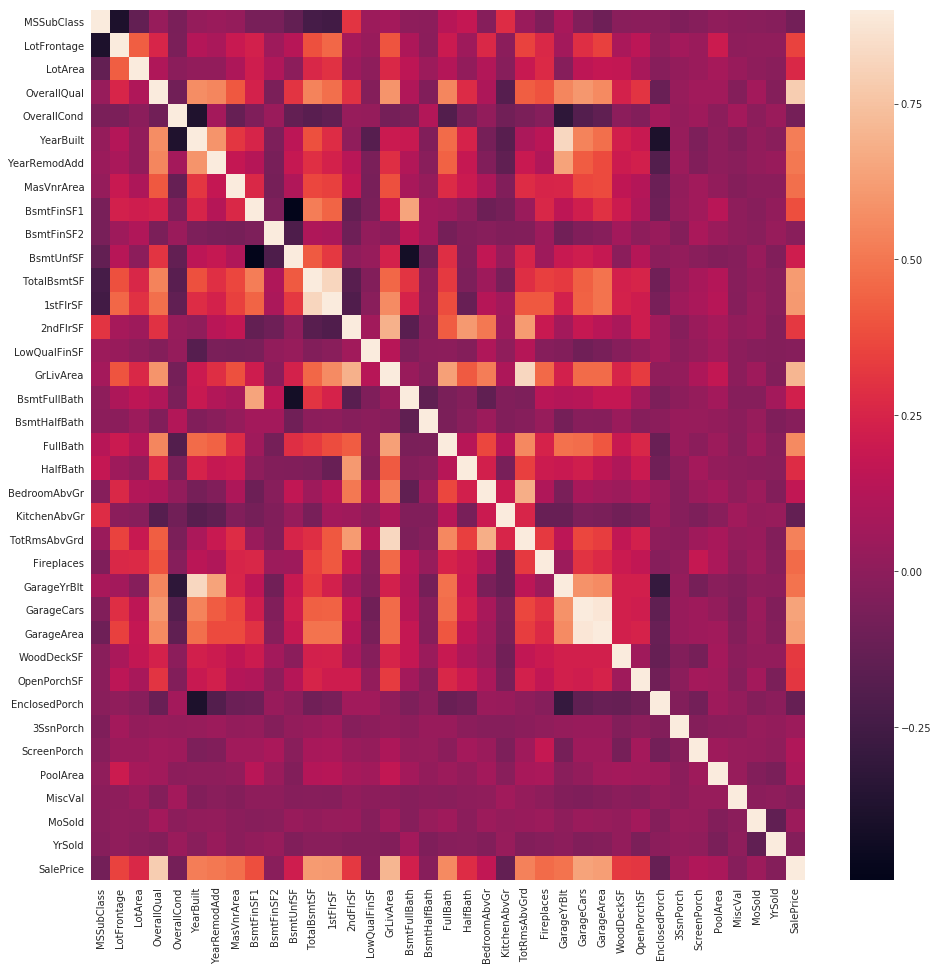

In [6]:
correlation_matrix = data_train.corr()
plt.subplots(figsize=(16,16))
sns.heatmap(correlation_matrix, vmax=0.9)

The map shows that the strong relationships with SalePrice have among others: 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF'.... There are a couple of them, so let's see 10 first variables with highest correlation with the target

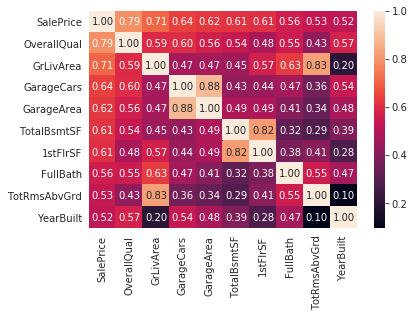

In [7]:
# create an pandas-type-Index with 10 variables with highest correlation with SalePrice 
cols = correlation_matrix.nlargest(10,'SalePrice')['SalePrice'].index
cm = np.corrcoef(data_train[cols].values.T)
ht = sns.heatmap(cm,annot=True, annot_kws={'size': 10},fmt='.2f',
                 yticklabels=cols.values, xticklabels=cols.values
                ) #annot=show correlation value, annot_kws=size of annotation, fmt=round values to .2
plt.show()

Now, it is more readable.

Are there any variables which information could be already described by another one? 'GarageCars' and 'GarageArea' are the example of a pair of variables that give the same information. We would need only one of them and we would take the one with higher value. The same case is with the pair 'TotalBsmtSF' and '1stFlrSF' as well as with 'TotRmsAbvGrd' and 'GrLivArea'.

'FullBath' and 'YearBuilt' in this dataset are slightly correlated with 'SalePrice'. The latter should also undergo time-series analysis in order to decide whether it is significant to 'SalePrice'. 'FullBath', on the other hand, compared to living area, does not seem to have a true impact in real life on the price of the house.

#  2. Data Processing

## 2.1 Outliers

Check the outliers on chosen variables:
* GrLivArea
* TotalBsmtSF

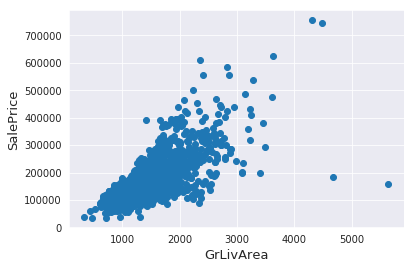

In [8]:
#    Another way to plot:
#data = pd.concat([data_train.SalePrice,data_train.GrLivArea],axis = 1)
#data.plot.scatter(x='GrLivArea',y='SalePrice',ylim=(0,800000))

fig, ax = plt.subplots()
ax.scatter(x = data_train['GrLivArea'], y = data_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We can see that two houses have large GrLivArea values (right side of the plot) while the prices are relatively low. We can define them as outliers and delete them. Outliers removal is note always safe.  We decided to delete these two as they are very huge and really bad.

In [9]:
data_train = data_train.drop(data_train[(data_train['GrLivArea'] > 4000) & 
                                        (data_train['SalePrice'] < 300000)].index)

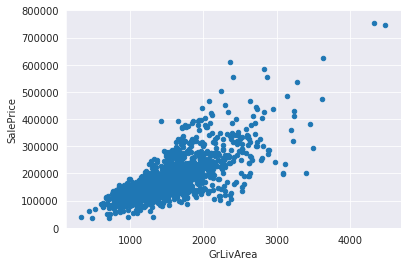

In [10]:
data = pd.concat([data_train.SalePrice,data_train.GrLivArea],axis = 1)
data.plot.scatter(x='GrLivArea',y='SalePrice',ylim=(0,800000))


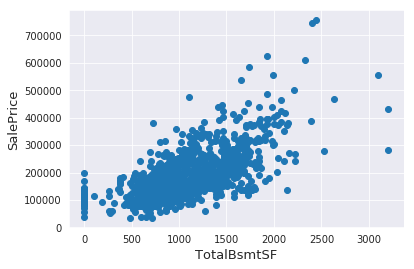

In [11]:
fig, ax = plt.subplots()
ax.scatter(x = data_train['TotalBsmtSF'], y = data_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

More or less all the observations of TotalBsmSF are "in-liners" (not outliners).

## 2.2 Target variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180932.92 and sigma = 79467.79



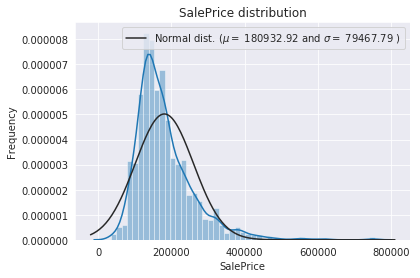

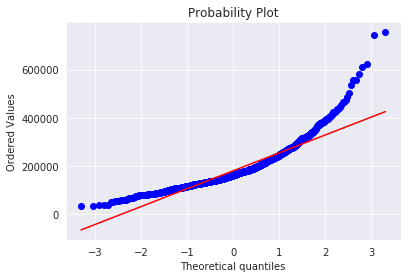

In [12]:
sns.distplot(data_train['SalePrice'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data_train['SalePrice'], plot=plt)
plt.show()

SalePrice variable is not normal but right skewed -> does not follow the diagonal line and has positive skewness.
If we want to use linear models efficiently we have to transform the data so it will be normally distributed.

In [13]:
# log transformation usually works well with skewness
data_train['SalePrice'] = np.log1p(data_train['SalePrice'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 12.02 and sigma = 0.40



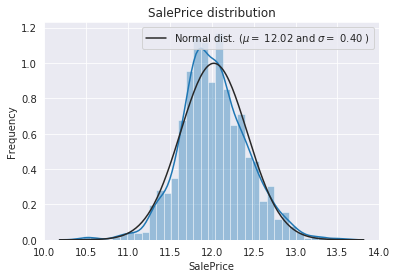

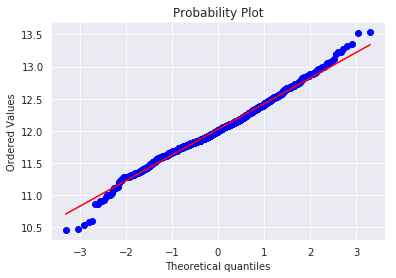

In [14]:
sns.distplot(data_train['SalePrice'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data_train['SalePrice'], plot=plt)
plt.show()

## 2.3 İmpute null and missing values

**Join train and test datasets in the same dataframe**

In [15]:
print(data_train.shape)
print(data_test.shape)

(1458, 80)
(1459, 79)


In [16]:
ntrain = data_train.shape[0]
ntest = data_test.shape[0]
ytrain = data_train.SalePrice.values

all_data = pd.concat((data_train,data_test)).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)
print(all_data.shape)

(2917, 79)


In [17]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.DataFrame(
                            {'Total' : total[total > 0],
                             'Missing Ratio': percent[percent > 0]
                            }
                            )
missing_data

# other versions:
#total = all_data.isnull().sum() 
#total = total.drop(total[total == 0].index).sort_values(ascending=False)
#percent = (total / len(all_data)) * 100
#missing_data = pd.concat([total,percent], axis = 1, keys=['Total','Missing ratio'])

,Total,Missing Ratio
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageFinish,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageCond,159,0.054508


Data description says NaN means: "No Pool" in case of 'PoolQC', no misc feature for "MiscFeature", no alley, no fence and no fireplace etc..

In [18]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [19]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
# all_data.loc[all_data.LotFrontage.isna(),'LotFrontage'] = all_data[~all_data.LotFrontage.isna()].LotFrontage.mean()


In [20]:
# Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

# Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

# For all these categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

# missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
# NA most likely means no masonry veneer for these houses. 
# We can fill 0 for the area and None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

# Only one NA value, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

# Both Exterior 1 & 2 have only one missing value -> substitute in the most common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

#Fill in again with most frequent which is "WD"
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



In [21]:
# all records are "AllPub", except for one "NoSeWa" and 2 NA . 
# Since the house with 'NoSewa' is in the training set, 
# this feature won't help in predictive modelling. We can then safely remove it.
all_data = all_data.drop(['Utilities'], axis=1)



In [22]:
#Check remaining missing values if any 
total = all_data.isnull().sum()
total[total > 0]

Series([], dtype: int64)

**Transforming some numerical variables that are really categorical**

In [23]:
#The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
#Overall condition
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

## 2.4 Label Encoding

In [24]:
# check which columns are categorical
all_data.columns[all_data.dtypes == "object"]

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'MoSold', 'Neighborhood', 'OverallCond', 'PavedDrive', 'PoolQC',
       'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street',
       'YrSold'],
      dtype='object')

In [25]:
# identify and create distinct values in categorical columns
from sklearn.preprocessing import LabelEncoder
for col in all_data.columns[all_data.dtypes == "object"]:
    all_data[col] = all_data[col].factorize()[0]


## 2.5 Split training and valdiation set

In [26]:
# after features engineering split back the dataset into train and test parts.
data_train = all_data.iloc[:ntrain]
data_test = all_data.iloc[ntrain:]

In [27]:
# split train data into two groups: training and validation set
# that we will use for tuning the model
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(data_train, ytrain, test_size=0.3, random_state=42)

# 3. XGBoost
## 3.1 Parameter Tuning

In [28]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from bayes_opt import BayesianOptimization

# we will use hyperoptimastion to measure best values of parameters of XGBRegression model
# however, we train the model with n_jobs = 4, learning rate lowest possible 0.01, and seed=42
dtrain = xgb.DMatrix(data_train, label=ytrain)

def xgb_evaluate(max_depth, n_estimators,min_child_weight,subsample,
                 colsample_bytree,colsample_bylevel,reg_lambda):
    params = {
              'max_depth': int(max_depth),
              'n_estimators': n_estimators,
              'min_child_weight': min_child_weight,
              'n_jobs': 4,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'learning_rate': 0.01,
              'reg_lambda': reg_lambda,
              'seed': 42,
              'silent':True
    }

    cv_result = xgb.cv(params, dtrain, num_boost_round = 500, nfold = 5, early_stopping_rounds=10)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 5), 
                                             'n_estimators': (500,3500),
                                             'min_child_weight': (1.5,7.5),
                                             'subsample':(0.3,1.0),
                                             'colsample_bytree': (0.01,1.0),
                                             'colsample_bylevel': (0.01,0.2),
                                             'reg_lambda': (0.1,10.0)
                                             })

xgb_bo.maximize(init_points = 3, n_iter = 50, acq='ei')

|   iter    |  target   | colsam... | colsam... | max_depth | min_ch... | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.1618   |  0.1394   |  0.5076   |  4.07     |  3.75     |  1.87e+03 |  1.219    |  0.3444   |
|  2        | -0.1768   |  0.1586   |  0.7768   |  3.496    |  4.108    |  3.362e+0 |  6.25     |  0.5924   |
|  3        | -0.1877   |  0.1988   |  0.27     |  3.251    |  2.126    |  3.477e+0 |  8.667    |  0.575    |
|  4        | -0.1525   |  0.1572   |  0.4756   |  4.362    |  7.438    |  2.555e+0 |  0.3067   |  0.7904   |
|  5        | -0.1638   |  0.05257  |  0.5073   |  4.776    |  7.348    |  500.5    |  2.269    |  0.6073   |
|  6        | -0.1872   |  0.01386  |  0.5973   |  3.977    |  1.527    |  2.656e+0 |  9.97     |  0.5706   |
|  7        | -0.1518   |  0.1406   |  1.0      |  5.0      |  7.5      |  2.244e+0 |  0.1      |  1.0      |
|  8      

In [29]:
# Bayesian Optimalisation gives us a hint about best paramteres
# after 53 loops best parameters we get are:
model = xgb.XGBRegressor(colsample_bylevel=0.25,colsample_bytree=0.6,max_depth=4,min_child_weight=4.8,n_estimators=3000,reg_lambda=0.1,subsample=0.8, learning_rate=0.01, n_jobs=4,seed=42)

# check the accuracy of cross valuation method
model.fit(train_x, train_y, early_stopping_rounds=5, eval_set=[(val_x,val_y)], verbose=False)
print("Valuated accuracy:", np.sqrt(mean_squared_log_error(model.predict(val_x), val_y)))
print("Trained accuracy:", np.sqrt(mean_squared_log_error(model.predict(train_x), train_y)))

# check the accuracy of the full train dataset
accuracy = cross_val_score(model, data_train, ytrain, cv=5, scoring="neg_mean_squared_log_error")
print("Accuracy of train data:", np.sqrt(-accuracy.mean()))


Valuated accuracy: 0.009942183867506976
Trained accuracy: 0.005978091268453409
Accuracy of train data: 0.009101185475204639


## 3.1 Training data

In [30]:
# training the model of the full dataset
model.fit(data_train, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.25,
       colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=4.8, missing=None, n_estimators=3000,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=42,
       silent=True, subsample=0.8)

# 4. Prediction and submition

In [31]:
y_pred = model.predict(data_test)
Y_pred = np.expm1(y_pred)
Y_pred

array([122230.92, 156933.53, 187407.6 , ..., 174029.53, 120831.19,
       236227.72], dtype=float32)

In [32]:
submission = pd.DataFrame({
    "Id": data_test_ID, 
    "SalePrice": Y_pred 
})
submission.to_csv('submission.csv', index=False)

# 5. Refrences
* [Comprehensive Data Explorartion with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by **by Pedro Marcellino**: Great basic data analysis
* [Stacked Regression to predict House Prices](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) by **by Sergine**: Best structured kernel on modelling I have found so far (for basic learning of machine learning)
* [House Price Prediction EDA/XGBoost - kernel prepared by tooezy](https://www.kaggle.com/tooezy/house-price-prediction-eda-xgboost)